In [1]:
import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.distributions import Categorical

from utils.minipacman import MiniPacman
from utils.multiprocessing_env import SubprocVecEnv
from utils.actor_critic import ActorCritic, RolloutStorage

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from IPython.core.debugger import set_trace
from IPython import display

In [2]:
ACTOR_CRITIC_PATH = os.path.join("training", "actor_critic")
ENVIRONMENT_PATH = os.path.join("training", "environment_model")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
#7 different pixels in MiniPacman
pixels = (
    (0.0, 1.0, 1.0),
    (0.0, 1.0, 0.0), 
    (0.0, 0.0, 1.0),
    (1.0, 1.0, 1.0),
    (1.0, 1.0, 0.0), 
    (0.0, 0.0, 0.0),
    (1.0, 0.0, 0.0),
)
pixel_to_categorical = {pix:i for i, pix in enumerate(pixels)} 
num_pixels = len(pixels)

#For each mode in MiniPacman there are different rewards
mode_rewards = {
    "regular": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    "avoid":   [0.1, -0.1, -5, -10, -20],
    "hunt":    [0, 1, 10, -20],
    "ambush":  [0, -0.1, 10, -20],
    "rush":    [0, -0.1, 9.9]
}
reward_to_categorical = {mode: {reward:i for i, reward in enumerate(mode_rewards[mode])} for mode in mode_rewards.keys()}

In [4]:
def pix_to_target(next_states):
    target = []
    for pixel in next_states.transpose(0, 2, 3, 1).reshape(-1, 3):
        target.append(pixel_to_categorical[tuple([np.ceil(pixel[0]), np.ceil(pixel[1]), np.ceil(pixel[2])])])
    return target

def target_to_pix(imagined_states):
    pixels = []
    to_pixel = {value: key for key, value in pixel_to_categorical.items()}
    for target in imagined_states:
        pixels.append(list(to_pixel[target]))
    return np.array(pixels)

def rewards_to_target(mode, rewards):
    target = []
    for reward in rewards:
        target.append(reward_to_categorical[mode][reward])
    return target

def plot(frame_idx, rewards, losses):
    display.clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('loss %s' % losses[-1])
    plt.plot(losses)
    plt.show()

In [5]:
class BasicBlock(nn.Module):
    def __init__(self, in_shape, n1, n2, n3):
        super(BasicBlock, self).__init__()
        
        self.in_shape = in_shape
        self.n1 = n1
        self.n2 = n2
        self.n3 = n3
        
        self.maxpool = nn.MaxPool2d(kernel_size=in_shape[1:])
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_shape[0] * 2, n1, kernel_size=1, stride=2, padding=6),
            nn.ReLU(),
            nn.Conv2d(n1, n1, kernel_size=10, stride=1, padding=(5, 6)),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_shape[0] * 2, n2, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(n2, n2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(n1 + n2,  n3, kernel_size=1),
            nn.ReLU()
        )
        
    def forward(self, inputs):
        x = self.pool_and_inject(inputs)
        x = torch.cat([self.conv1(x), self.conv2(x)], 1)
        x = self.conv3(x)
        x = torch.cat([x, inputs], 1)
        return x
    
    def pool_and_inject(self, x):
        pooled = self.maxpool(x)
        tiled = pooled.expand((x.size(0),) + self.in_shape)
        out = torch.cat([tiled, x], 1)
        return out

In [6]:
class EnvModel(nn.Module):
    def __init__(self, in_shape, num_actions, num_pixels, num_rewards):
        super(EnvModel, self).__init__()
        width  = in_shape[1]
        height = in_shape[2]
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_shape[0] + num_actions, 64, kernel_size=1),
            nn.ReLU()
        )
        
        self.basic_block1 = BasicBlock((64, width, height), 16, 32, 64)
        self.basic_block2 = BasicBlock((128, width, height), 16, 32, 64)
        
        self.image_conv = nn.Sequential(
            nn.Conv2d(192, 256, kernel_size=1),
            nn.ReLU()
        )
        self.image_fc = nn.Linear(256, num_pixels)
        
        self.reward_conv = nn.Sequential(
            nn.Conv2d(192, 64, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=1),
            nn.ReLU()
        )
        self.reward_fc    = nn.Linear(64 * width * height, num_rewards)
        
    def forward(self, inputs):
        batch_size = inputs.size(0)
        
        x = self.conv(inputs)
        x = self.basic_block1(x)
        x = self.basic_block2(x)
        
        image = self.image_conv(x)
        image = image.permute(0, 2, 3, 1).contiguous().view(-1, 256)
        image = self.image_fc(image)

        reward = self.reward_conv(x)
        reward = reward.view(batch_size, -1)
        reward = self.reward_fc(reward)
        
        return image, reward

In [7]:
def get_action(state, actor_critic):
    if state.ndim == 4:
        state = torch.FloatTensor(np.float32(state))
    else:
        state = torch.FloatTensor(np.float32(state)).unsqueeze(0)
    
    state = state.to(DEVICE)
    with torch.no_grad():
        action = actor_critic.act(state)
        
    action = action.data.cpu().squeeze(1).numpy()
    return action

def play_games(envs, frames, actor_critic):
    states = envs.reset()
    
    for frame_idx in range(frames):
        actions = get_action(states, actor_critic)
        next_states, rewards, dones, _ = envs.step(actions)
        
        yield frame_idx, states, actions, rewards, next_states, dones
        
        states = next_states

# Training

In [ ]:
mode = "regular"
num_envs = 16

def make_env():
    def _thunk():
        env = MiniPacman(mode, 1000)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

state_shape = envs.observation_space.shape
num_actions = envs.action_space.n

In [ ]:
env_model = EnvModel(envs.observation_space.shape, envs.action_space.n, num_pixels, len(mode_rewards["regular"]))
actor_critic = ActorCritic(envs.observation_space.shape, envs.action_space.n)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(env_model.parameters())

env_model = env_model.to(DEVICE)
actor_critic = actor_critic.to(DEVICE)

In [ ]:
checkpoint = torch.load(os.path.join(ACTOR_CRITIC_PATH, "actor_critic_checkpoint"))
actor_critic.load_state_dict(checkpoint['actor_critic_state_dict'])

In [ ]:
reward_coef = 0.1
num_updates = 5000

losses = []
all_rewards = []

for frame_idx, states, actions, rewards, next_states, dones in play_games(envs, num_updates, actor_critic):
    states      = torch.FloatTensor(states)
    actions     = torch.LongTensor(actions)

    batch_size = states.size(0)
    
    onehot_actions = torch.zeros(batch_size, num_actions, *state_shape[1:])
    onehot_actions[range(batch_size), actions] = 1
    inputs = torch.cat([states, onehot_actions], 1)
    
    inputs = inputs.to(DEVICE)

    imagined_state, imagined_reward = env_model(inputs)

    target_state = pix_to_target(next_states)
    target_state = torch.LongTensor(target_state).to(DEVICE)
    
    target_reward = rewards_to_target(mode, rewards)
    target_reward = torch.LongTensor(target_reward).to(DEVICE)

    optimizer.zero_grad()
    image_loss  = criterion(imagined_state, target_state)
    reward_loss = criterion(imagined_reward, target_reward)
    loss = image_loss + reward_coef * reward_loss
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    all_rewards.append(np.mean(rewards))
    
    if frame_idx % 10 == 0:
        plot(frame_idx, all_rewards, losses)

# Testing

In [22]:
mode = "regular"
env = MiniPacman(mode, 1000)
batch_size = 1
num_actions = env.action_space.n
state_shape = env.observation_space.shape

checkpoint = torch.load(os.path.join("training", "environment_model", "env_model"), map_location=DEVICE)
env_model = EnvModel(state_shape, num_actions, num_pixels, len(mode_rewards["regular"]))
env_model.load_state_dict(checkpoint)
env_model.to(DEVICE)

actor_critic = ActorCritic(state_shape, num_actions)
checkpoint = torch.load(os.path.join("training", "actor_critic", "actor_critic_checkpoint"), map_location=DEVICE)
actor_critic.load_state_dict(checkpoint['actor_critic_state_dict'])
actor_critic.to(DEVICE)

print("loading models successfully!")

loading models successfully!


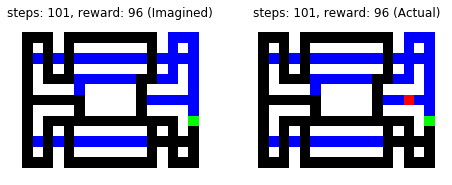

In [26]:
done = False
state = env.reset()
iss = []
ss  = []

steps = 0
total_imagined_rewards = 0
total_reawards = 0

while not done:
    steps += 1
    actions = get_action(state, actor_critic)
    onehot_actions = torch.zeros(batch_size, num_actions, *state_shape[1:])
    onehot_actions[range(batch_size), actions] = 1
    state = torch.FloatTensor(state).unsqueeze(0)
    
    inputs = torch.cat([state, onehot_actions], 1).to(DEVICE)

    imagined_state, imagined_reward = env_model(inputs)
    imagined_state = F.softmax(imagined_state, dim=-1)
    iss.append(imagined_state)
    
    next_state, reward, done, _ = env.step(actions[0])
    ss.append(state)
    state = next_state
    
    imagined_image = target_to_pix(imagined_state.view(batch_size, -1, len(pixels))[0].max(1)[1].data.cpu().numpy())
    imagined_image = imagined_image.reshape(15, 19, 3)
    state_image = torch.FloatTensor(next_state).permute(1, 2, 0).cpu().numpy()
    
    total_imagined_rewards +=  F.softmax(imagined_reward, dim=-1).max(1)[1].item()
    total_reawards += reward
    
    display.clear_output(wait=True)
    plt.figure(figsize=(12, 5))
    plt.subplot(131)
    plt.title(f"steps: {steps}, reward: {total_imagined_rewards} (Imagined)")
    plt.imshow(imagined_image)
    plt.axis('off')
    
    
    plt.subplot(132)
    plt.title(f"steps: {steps}, reward: {total_reawards} (Actual)")
    plt.imshow(state_image)
    plt.axis('off')
    fig = plt.gcf()
    fig.savefig(os.path.join("results", "env_model_result.pdf"), bbox_inches="tight")
    plt.show()
    time.sleep(0.1)
    
    if steps > 100:
        break